# requirements

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
import keras 
# from tensorflow import keras
from keras.layers import Input,Dense 
from keras.models import Model,Sequential
from keras.optimizers import Adam
from keras.optimizers import SGD,Adam
from keras.regularizers import l2
from keras.metrics import RootMeanSquaredError
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping,ModelCheckpoint,TerminateOnNaN
from keras import backend as K
print(tf.__version__)

2.3.1


In [3]:
%pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [4]:
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import Sklearn
import kerastuner as kt

In [5]:
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.manifold import TSNE

In [6]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [7]:
from tqdm import tqdm_notebook as tn 

In [8]:
import itertools

In [9]:
plt.rcParams["figure.figsize"] = [20, 10] 
plt.rcParams["axes.grid"]=True
plt.rcParams["font.size"]=16

# report function

In [10]:
def regression_report(y_true,y_pred):
    print(f"""
    MSE:     {metrics.mean_squared_error(y_true,y_pred)}
    RMSE:    {metrics.mean_squared_error(y_true,y_pred,squared=False)}
    MAE      {metrics.median_absolute_error(y_true,y_pred)}
    R2:      {metrics.r2_score(y_true,y_pred)}""")

# generated data 

Завантажимо дані варіанту

In [11]:
X_data = np . linspace (-1 , 1 , 100)
num_coef=5
coef =[ 10, 2 , 30 , 4 , 5 ]
y_data=0
for i in range(num_coef):
    y_data += coef[i]*np.power(X_data,i)
    y_data += np.random.randn(*X_data.shape)*1.5

In [12]:
X_data = X_data.reshape(-1,1)
y_data = y_data.reshape(-1,1)

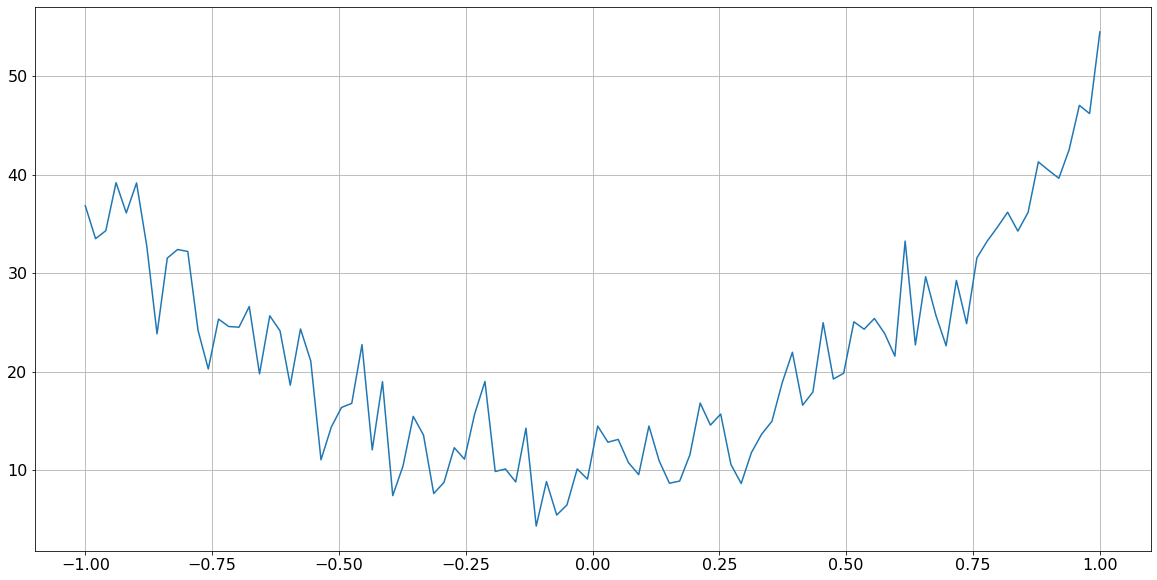

In [13]:
plt.plot(X_data,y_data);

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X_data,
                                                 y_data,
                                                 test_size=0.2,
                                                 random_state=0)

Let's take n=3 as max degree of polynomial regression

In [15]:
n = 3

## Sklearn

Спробуємо спершу Sklearn щоб оцінити результат за різних бібліотек 

In [16]:
sklearn_pipeline=Pipeline([
    ("poly_features",PolynomialFeatures(n)),
    ("scaler",StandardScaler()),
    ("lr",LinearRegression())
])

In [17]:
sklearn_pipeline.fit(X_train,y_train)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()), ('lr', LinearRegression())])

In [18]:
y_pred = sklearn_pipeline.predict(X_data)

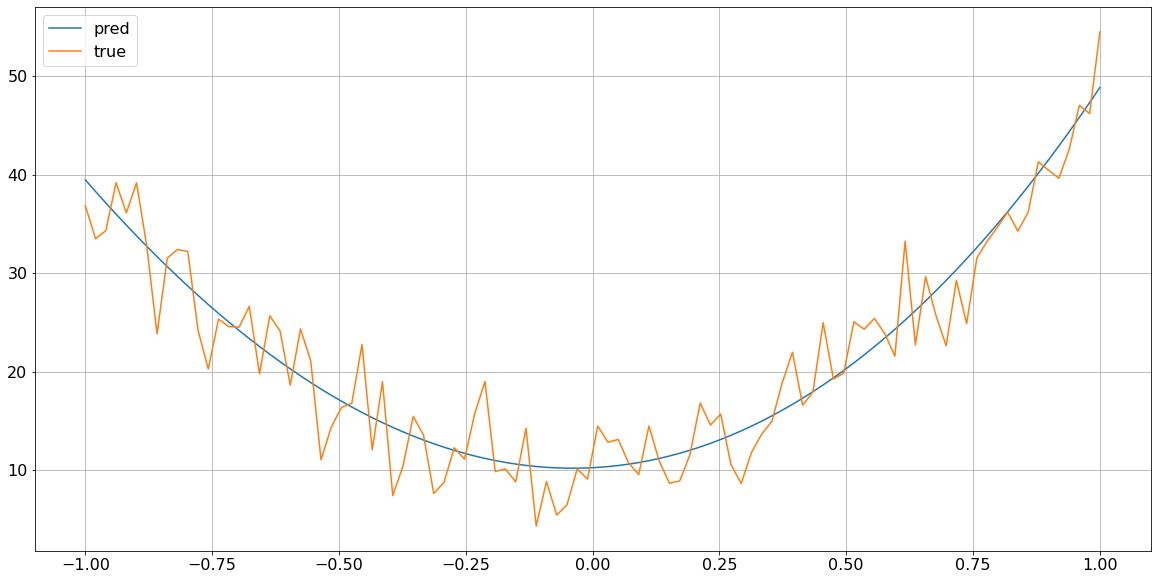

In [19]:
plt.plot(X_data,y_pred,label="pred")
plt.plot(X_data,y_data,label="true")
plt.legend();

In [20]:
regression_report(y_test,sklearn_pipeline.predict(X_test))


    MSE:     11.924465648580611
    RMSE:    3.453181959958179
    MAE      2.4086110181381084
    R2:      0.8729870339494765


## Keras

Тепер спробуємо отримати той самий результат за допомогою фреймворку Keras. Так як дані прості, поки що можна не зберегати моделі. Але для наступного датасету зберігання буде виконано, оскільки дані там набагато більшої розмірності

In [21]:
# Apply Polynomial features first
X_train_poly = PolynomialFeatures(n).fit_transform(X_train)
X_test_poly = PolynomialFeatures(n).fit_transform(X_test)
X_data_poly = PolynomialFeatures(n).fit_transform(X_data)

# Apply standard scaling (train.mean & train.std for test too)
scaler = StandardScaler().fit(X_train_poly)
X_train_poly_scaled = scaler.transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)
X_data_poly_scaled = scaler.transform(X_data_poly)

In [22]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Скористаємося keras-tuner для пошуку оптимальних гіперпараметрів

In [23]:
def build_model(hp):
    model = Sequential([
        Dense(1,input_shape=(4,),
              activation="linear",
              kernel_initializer='ones',
              kernel_regularizer=tf.keras.regularizers.L2(
                  l2=hp.Choice("regularization_parameter",
                               values=[0.01,0.1,1.0])))
    ])
    
    model.compile(loss="mean_squared_error",
                  optimizer=tf.keras.optimizers.SGD(
                              learning_rate=hp.Float('learning_rate',
                                                     1e-4,1e-1),
                              momentum=hp.Choice('momentum',
                                     values = [0.0,0.5,0.9,0.99])),
                  metrics=["mae",root_mean_squared_error,
                           'mean_squared_logarithmic_error'])
    return model

In [24]:
hp = kt.HyperParameters()

In [25]:
rm -rf generated_data_rand_dir/

In [26]:
# tuner = kt.Hyperband(build_model,
#                         objective='val_loss',
#                         seed=0,
#                         max_epochs=100,
#                         directory='generated_data_dir')
tuner = kt.RandomSearch(build_model,
                        objective='val_loss',
                        seed=0,
                        max_trials=5,
                        directory='generated_data_rand_dir')

Щодо коментаря у скрипті вище, можна побачити використання Hyperband, але для кращого порівняння моделей та зображень історії функції втрат було використано RandomSearch

In [27]:
rm -rf logs/

Callbacks дадут змогу створювати Checkpoints, щоб можна було використати модель де було перерване навчання. Також можна записати історію до tensorboard, використати EarlyStopping,та TerminateOnNaN якщо будуть expoding gradients

In [28]:
tuner.search(X_train_poly_scaled,
             y_train,
             epochs=100,
             validation_split=0.2,
             callbacks=[ModelCheckpoint('generated_data_best_model.h5',
                                        monitor='val_loss',
                                        mode="min",
                                        save_best_only=True,
                                        verbose=1),
                        EarlyStopping(monitor='val_loss',
                           mode="min",
                           verbose=1,
                           min_delta=0.1,
                           patience=5),
                        TerminateOnNaN(),
                        keras.callbacks.TensorBoard(log_dir='./logs/fit/gendata_rands')
                       ])

Trial 5 Complete [00h 00m 00s]
val_loss: 26.172344207763672

Best val_loss So Far: 14.984090805053711
Total elapsed time: 00h 00m 07s
INFO:tensorflow:Oracle triggered exit


In [29]:
best_model =  tuner.get_best_models()[0]

In [30]:
tuner.results_summary()

Results summary
Results in generated_data_rand_dir/untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
regularization_parameter: 0.01
learning_rate: 0.0918515216167194
momentum: 0.0
Score: 14.984090805053711
Trial summary
Hyperparameters:
regularization_parameter: 0.1
learning_rate: 0.0323130948913716
momentum: 0.0
Score: 23.69180679321289
Trial summary
Hyperparameters:
regularization_parameter: 0.1
learning_rate: 0.03577537233799758
momentum: 0.9
Score: 26.172344207763672
Trial summary
Hyperparameters:
regularization_parameter: 1.0
learning_rate: 0.06595185349284281
momentum: 0.5
Score: 68.31434631347656
Trial summary
Hyperparameters:
regularization_parameter: 1.0
learning_rate: 0.013924880132050597
momentum: 0.9
Score: 75.66371154785156


Оцінимо результати та історію навчання в tensorboard

In [31]:
%load_ext tensorboard

In [32]:
%tensorboard --logdir='logs/fit/gendata_rands'

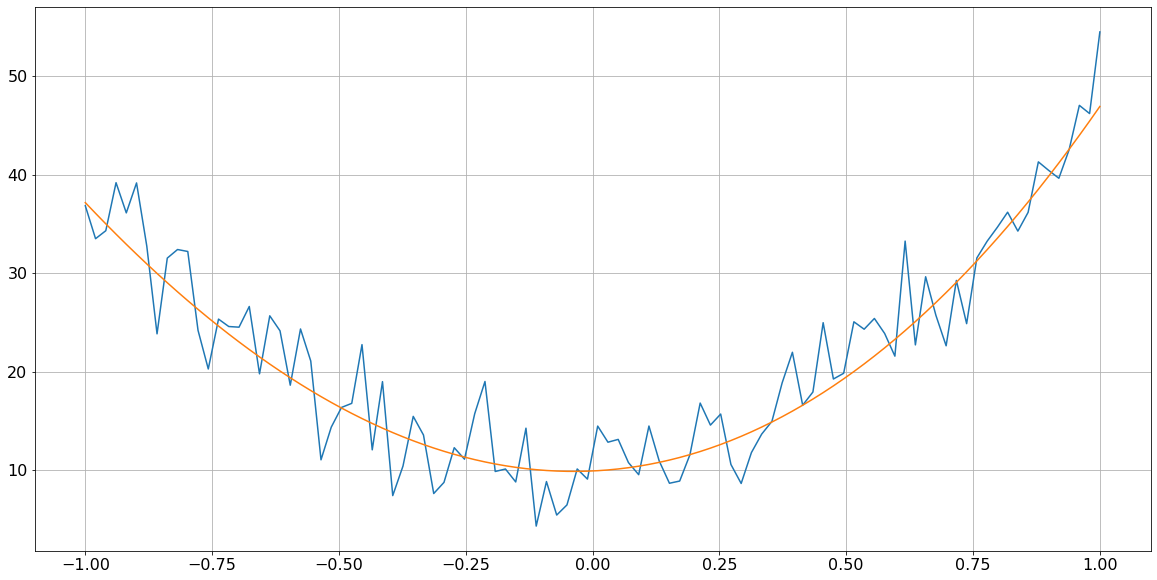

In [33]:
plt.plot(X_data,y_data)
plt.plot(X_data,best_model.predict(X_data_poly_scaled))

In [34]:
regression_report(y_test,best_model.predict(X_test_poly_scaled))


    MSE:     10.263840765143764
    RMSE:    3.2037229538684775
    MAE      2.0260236160468903
    R2:      0.890675113076756


Comparing to sklearn

In [35]:
regression_report(y_test,sklearn_pipeline.predict(X_test))


    MSE:     11.924465648580611
    RMSE:    3.453181959958179
    MAE      2.4086110181381084
    R2:      0.8729870339494765


Як бачимо, результати доволі схожі

# california housing

Let's do the same with california housing data

In [36]:
california_housing_data = fetch_california_housing(download_if_missing=True)

In [37]:
print(california_housing_data["DESCR"])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

From the description above we can see that it will be better to use ensemble models or trees or something else. Basic XGBoost and RandomForest will be used below after analysing keras model of polynomial regression.

In [38]:
X = california_housing_data["data"]
y = california_housing_data["target"]

In [39]:
X.shape,y.shape

((20640, 8), (20640,))

In [40]:
y = y.reshape(-1,1)

In [41]:
data = np.concatenate([X,y],axis=1)

In [42]:
data_scaled = StandardScaler().fit_transform(data)

In [43]:
# data_scaled_tsne_3d = TSNE(3,
#                            n_jobs=-1).fit_transform(data_scaled)

In [44]:
# pd.to_pickle(data_scaled_tsne_3d,"./data_scaled_tsne_3d.pkl")

Підвантажимо дані вже зниженої розмірності для зображення

In [45]:
data_scaled_tsne_3d = pd.read_pickle("./data_scaled_tsne_3d.pkl")

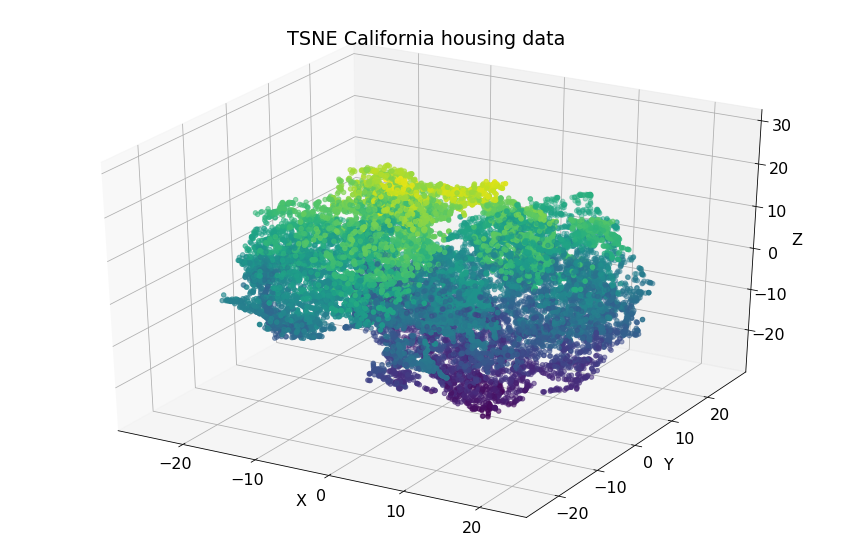

In [46]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data_scaled_tsne_3d[:,0],
           data_scaled_tsne_3d[:,1],
           data_scaled_tsne_3d[:,2],
           c=data_scaled_tsne_3d[:,2],
           marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("TSNE California housing data")
plt.show()

In [47]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

In [48]:
X_train.shape,y_train.shape

((15480, 8), (15480, 1))

In [49]:
n = 3

In [50]:
# Apply Polynomial features first
X_train_poly = PolynomialFeatures(n).fit_transform(X_train)
X_test_poly = PolynomialFeatures(n).fit_transform(X_test)

# Apply standard scaling (train.mean & train.std for test too)
scaler = StandardScaler().fit(X_train_poly)
X_train_poly_scaled = scaler.transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

In [51]:
def build_model(hp):
    model = Sequential([
        Dense(1,input_shape=X_train_poly_scaled[0].shape,
              activation="linear",
              kernel_initializer='ones',
              kernel_regularizer=tf.keras.regularizers.L2(
                  l2=hp.Choice("regularization_parameter",[0.01,1.0])))
    ])
    
    model.compile(loss="mean_squared_logarithmic_error",
                  optimizer=tf.keras.optimizers.SGD(
                      learning_rate=hp.Choice('learning_rate',
                                              values = [1e-3,1e-2,1e-1]),
                      momentum=hp.Choice('momentum',
                                         values = [0.0,0.5,0.9,0.99])),
                  metrics=["mae",root_mean_squared_error,
                           'mean_squared_logarithmic_error'])
    return model

In [52]:
mc = ModelCheckpoint('california_best_model.h5',
                     monitor='val_loss',
                     mode="min",
                     save_best_only=True,
                     verbose=1)
es_patient = EarlyStopping(monitor='val_loss',
                           mode="min",
                           verbose=1,
                           min_delta=0.1,
                           patience=5)
nan_t = TerminateOnNaN()

In [53]:
rm -rf house_data_dir/

In [54]:
tuner = kt.tuners.RandomSearch(build_model,
                     max_trials=100,
                     objective='val_loss',
                     directory='house_data_dir/')

In [55]:
rm -rf logs/fit/california_data/

In [56]:
tuner.search(X_train_poly_scaled,
             y_train,
             validation_split=0.2,
             epochs=100,
             callbacks=[mc,
                        es_patient,
                        tf.keras.callbacks.TerminateOnNaN(),
                        tf.keras.callbacks.TensorBoard('logs/fit/california_data')])

Trial 18 Complete [00h 00m 03s]
val_loss: 1.2526260614395142

Best val_loss So Far: 0.04569423943758011
Total elapsed time: 00h 01m 44s
INFO:tensorflow:Oracle triggered exit


In [57]:
%tensorboard --logdir logs/fit/california_data/

In [58]:
best_model = tuner.get_best_models()[0]

In [59]:
y_pred = best_model.predict(X_test_poly_scaled)

In [60]:
regression_report(y_test,y_pred)


    MSE:     14.72920944607244
    RMSE:    3.837865219894055
    MAE      0.3660903329849243
    R2:      -10.142869582072718


As we can see, Polynomial regression is not the best type of model for this dataset. However, we can use RandomForest and XGBoost to compare.

## sklearn and XGBoost

In [61]:
xgb = XGBRegressor(n_estimators=100,max_depth=5,n_jobs=-1)
xgb.fit(X_train_poly_scaled,y_train)
y_pred_test_xgb = xgb.predict(X_test_poly_scaled)

In [62]:
regression_report(y_test,y_pred_test_xgb)


    MSE:     0.22378536559806658
    RMSE:    0.47305957933231474
    MAE      0.211212895154953
    R2:      0.8307029883466934


In [63]:
random_forest_regressor = RandomForestRegressor(n_jobs=-1,random_state=0)
random_forest_regressor.fit(X_train_poly_scaled,y_train)
y_pred_test = random_forest_regressor.predict(X_test_poly_scaled)

<ipython-input-63-725ecc18815c>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest_regressor.fit(X_train_poly_scaled,y_train)


In [64]:
regression_report(y_test,y_pred_test)


    MSE:     0.28358206163580024
    RMSE:    0.5325242357262252
    MAE      0.22374004999999975
    R2:      0.7854658839503688


Отже, отримано базові навички для роботи з tensorflow, в особливості keras. Було створено поліноміальну регресію на основі класичної формули в sklearn, та лінійну модель в керас на основі поліноміальних даних. Оцінено  ефективність моделей у випадку простих згенерованих даних та реальних даних. 